In [1]:
# Gym 
import gym
from gym import wrappers
from gym.spaces.utils import flatdim

import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange, tqdm

import io
import base64
from IPython.display import HTML

# Comment out for debugging
import warnings
warnings.filterwarnings('ignore')

In [2]:
def play_video(ep_number: int):
    video = io.open(f"./gym-results/rl-video-episode-{ep_number}.mp4", 'r+b').read()
    encoded = base64.b64encode(video)
    return HTML(data='''
        <video width="360" height="auto" alt="test" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''
    .format(encoded.decode('ascii')))

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='valid')
    return y_smooth

100%|██████████| 10000/10000 [00:00<00:00, 10660.70it/s]


Text(0.5, 1.0, 'Rewards over 1299 episodes')

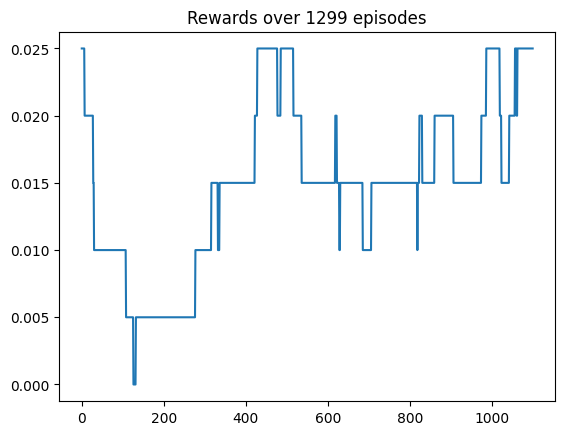

In [3]:
# Frozen Lake Environment
env = gym.make("FrozenLake-v1", is_slippery=False, new_step_api=True)
env = wrappers.RecordVideo(env, "./gym-results", new_step_api=True)
env.reset(seed=42)

# hyperparams
num_steps = 10000
random_rewards = [0]
random_lengths = [0]
ep_len = 0
for _ in trange(num_steps):
   action = env.action_space.sample() 
   observation, reward, done, info, _ = env.step(action)

   if done:
      random_rewards.append(reward)
      random_lengths.append(ep_len)
      observation = env.reset()
      ep_len = 0
   
   ep_len += 1
env.close()

plt.plot(smooth(random_rewards, 200))
plt.title(f"Rewards over {len(random_rewards)} episodes")

In [7]:

env = gym.make("FrozenLake-v1", is_slippery=False, new_step_api=True)
env = wrappers.RecordVideo(env, "./gym-results", new_step_api=True)
obs = env.reset(seed=42)

# hyperparams
num_steps = 10000
lr = 0.5
gamma = 0.99
epsilon = 0.01

# Q table
nS = flatdim(env.observation_space)
nA = flatdim(env.action_space)
q_table = np.zeros((nS, nA))
print(f"Q table shape: {q_table.shape}")

def policy(o, epsilon, q_table):
   if np.random.rand() < epsilon:
      return env.action_space.sample()

   return np.random.choice(np.where(q_table == q_table.max())[0])

q_rewards = [0]
q_lengths = [0]
p_bar = trange(num_steps)

ep_len = 0
for step in p_bar:
   action = policy(obs, epsilon, q_table[obs])
   next_obs, reward, done, info, _ = env.step(action)

   # Current table should be consistent 1 step into the future
   bellman_error = (reward + gamma * np.max(q_table[next_obs])) - q_table[obs, action]
   q_table[obs, action] += lr * bellman_error

   if done:
      q_rewards.append(reward)
      q_lengths.append(ep_len)
      q_table[next_obs] = 0
      obs = env.reset()
      ep_len = 0

   p_bar.set_description(f"Cumulative R: {np.cumsum(q_rewards)[-1]}")
   obs = next_obs
   ep_len += 1
env.close()

plt.subplot(1,2,1)
plt.plot(smooth(random_rewards, 100), label="random")
plt.plot(smooth(q_rewards, 100), label="q_learning")
plt.title(f"Cumulative Rewards over {len(q_rewards)} episodes")
plt.legend()

plt.subplot(1,2,2)
plt.imshow(np.mean(q_table, axis=1).reshape(int(np.sqrt(nS)), int(np.sqrt(nS))))
plt.title("Value function")

Q table shape: (16, 4)


Cumulative R: 0.0:   0%|          | 12/10000 [00:00<01:47, 92.87it/s]

(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)


Cumulative R: 0.0:   0%|          | 12/10000 [00:00<01:47, 92.87it/s]

(4,)


Cumulative R: 0.0:   1%|          | 114/10000 [00:00<00:27, 363.99it/s]

(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)


Cumulative R: 0.0:   1%|          | 114/10000 [00:00<00:27, 363.99it/s]

(4,)
(4,)
(4,)
(4,)


Cumulative R: 2.0:   2%|▏         | 180/10000 [00:00<00:20, 469.02it/s]

(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)


Cumulative R: 2.0:   2%|▏         | 180/10000 [00:00<00:20, 469.02it/s]

(4,)
(4,)


Cumulative R: 9.0:   3%|▎         | 296/10000 [00:00<00:20, 466.65it/s]

(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)


Cumulative R: 24.0:   4%|▍         | 408/10000 [00:01<00:18, 516.51it/s]

(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)


Cumulative R: 35.0:   5%|▌         | 522/10000 [00:01<00:20, 456.80it/s]

(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)


Cumulative R: 49.0:   6%|▋         | 634/10000 [00:01<00:18, 504.74it/s]

(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)


Cumulative R: 65.0:   7%|▋         | 746/10000 [00:01<00:17, 523.68it/s]

(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)


Cumulative R: 73.0:   8%|▊         | 800/10000 [00:01<00:21, 431.53it/s]

(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)


Cumulative R: 86.0:   9%|▉         | 912/10000 [00:02<00:19, 476.24it/s]

(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)


Cumulative R: 103.0:  10%|█         | 1027/10000 [00:02<00:17, 520.67it/s]

(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)


Cumulative R: 121.0:  12%|█▏        | 1155/10000 [00:02<00:15, 576.98it/s]

(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)


Cumulative R: 136.0:  13%|█▎        | 1280/10000 [00:02<00:14, 600.19it/s]

(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)


Cumulative R: 150.0:  13%|█▎        | 1341/10000 [00:02<00:17, 498.75it/s]

(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)


Cumulative R: 160.0:  15%|█▍        | 1460/10000 [00:02<00:17, 488.97it/s]


(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)
(4,)


KeyboardInterrupt: 

In [5]:
play_video(1000)